In [1]:
import sys
import math
import numpy as np
from collections import defaultdict
from Bio import SeqIO, Seq, SeqRecord
import pickle

In [2]:
class Modification:
    '''
    Class to represent a modification
    '''
    def __init__(self, position, calling):
        self.position = position
        self.calling = calling

In [3]:
class BED:
    '''
    Class to represent an entry in a BED file
    '''
    def __init__(self, chro, start, end, quality, strand):
        self.chro = chro
        self.start = start
        self.end = end
        self.quality = quality
        self.strand = strand

# Functions

In [4]:
def build_modification_map(f,emat):
    import random
    mod_map = defaultdict(list)
    read_dict = {}
    ct = 0
    read = ''
    edits = []
    groundTruth = ''
    aPositions = []

    for line in f:
        line = line.rstrip()
        # print(line)
        if line.startswith('read_'):
            read += line
            ct += 1
        elif ct == 1:
            edits = [int(i) for i in line]
            ct += 1
        elif ct == 2:
            groundTruth = line
            ct += 1
        elif ct == 3:
            aPositions = [int(i) for i in line.split(',')]
            ct = 0
            read_dict[read] = (edits, groundTruth, aPositions)
            footprint_indices = [i for i, x in enumerate(groundTruth) if x == 'y'] 
            # Footprint_As = random.sample(footprint_indices, len(footprint_indices)//4)
            #### need to edit this so that all unedited A's are set to 0.03 ########
            # for i in range(len(edits)):
            #     if edits[i] != 0:
            #         mod_map[read].append(Modification(i, 0.97))
            #     elif i in Footprint_As:
            #         mod_map[read].append(Modification(i, 0.03))
            for i in aPositions:
                if edits[i] == 1:
                    mod_map[read].append(Modification(i, emat[0]))
                else:
                    mod_map[read].append(Modification(i, emat[1]))
                
                
            read = ''
            edits = []
            groundTruth = ''
            aPositions = []

    return mod_map, read_dict
            
        

In [5]:
def build_modification_map2(f):
    import random
    mod_map = defaultdict(list)
    read_dict = {}
    ct = 0
    read = ''
    edits = []
    groundTruth = ''
    aPositions = []

    for line in f:
        line = line.rstrip()
        # print(line)
        if line.startswith('read_'):
            read += line
            ct += 1
        elif ct == 1:
            edits = [int(i) for i in line]
            ct += 1
        elif ct == 2:
            groundTruth = line
            ct += 1
        elif ct == 3:
            aPositions = [int(i) for i in line.split(',')]
            ct = 0
            read_dict[read] = (edits, groundTruth, aPositions)
            for i in aPositions:
                if edits[i] == 1:
                    mod_map[read].append(Modification(i, 0.97))
                else:
                    mod_map[read].append(Modification(i, 0.03))
                
                
            read = ''
            edits = []
            groundTruth = ''
            aPositions = []

    return mod_map, read_dict
            
        

In [6]:
def make_calling_vector(mod_list, read_length):
    calling_vec = [-1] * (read_length + 1)

    for m in mod_list:
        position = m.position
        calling = m.calling
        if 0 <= position <= read_length:
            calling_vec[position] = calling

    return calling_vec

## Score Distribution

In [15]:
mod_file = '/data16/liam/testing/HMM_test_data_AC50.txt'

scores = {}
with open (mod_file) as mf:
    
    mod_map, read_dict = build_modification_map2(mf)
    for read, modList in mod_map.items():
        # check that edits and ground truth are same length
        # print(''.join(str(i) for i in read_dict[read][0]))
        # print(read_dict[read][1])
        assert len(read_dict[read][0]) == len(read_dict[read][1]), 'edits and ground truth are not the same length'

        s = [mod_map[read][i].calling for i in range(len(mod_map[read]))]
        scores[read] = [float(i) for i in s]

        

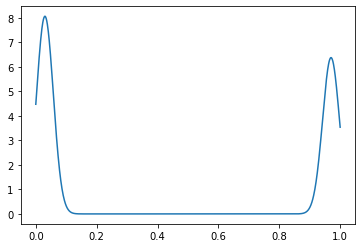

In [16]:
# plot score distribution 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import linspace

score_list = []
for read, score in scores.items():
    score_list += score

score_list = np.array(score_list)
kde = gaussian_kde(score_list)



dist_space = linspace( 0, 1, 1000 )

plt.plot( dist_space, kde(dist_space) )




In [18]:
# vectorize kde function
vector = kde(dist_space)
print(len(vector))

1000


In [19]:
# write vector to file
with open('/data16/liam/testing/kde_vector_AC50.txt', 'w') as f:
    for i in vector:
        f.write(str(i) + '\n')

### Score Distribution of Tad Accessible/Unaccessible Regions
#### with lower editing rates, the HMM tends to overpredict shadows. One idea we have is to introduce a tad accessibility score for kmers. This will enable us to enable multiple paths that we can iterate through with dynamic programming/backtracking algorithms to find the optimal path of shadows.
#### in real data, the accessibility score will likely be a measurement of base editor sequence preference, number of A's in kmer, and number of edits in kmer (in shadowless data)
#### in simulated data, I will just use number of As in kmer

In [38]:
reads = '/data16/liam/testing/HMM_test_data_AC50.txt'
tad_access_scores = {}
with open(reads) as f:
    mod_map, read_dict = build_modification_map2(f)
    for read in read_dict:
        kmer_dict = {}
        for i in range(len(read_dict[read][0])-6):
            kmer = read_dict[read][0][i:i+6]
            # count number of A's in kmer
            num_A = 0
            for base in range(len(kmer)):
                if i + base in read_dict[read][2]:
                    num_A += 1

            # calculate TAD access score
            tad_access_score = num_A / len(kmer)
            # calculate TAD inaccess score
            tad_inaccess_score = (len(kmer) - num_A) / len(kmer) 

            # kmer_name = ''.join(str(i) for i in kmer)
            kmer_name = str(i) + '_' + str(i+6)
            if kmer_name not in kmer_dict:
                kmer_dict[kmer_name] = (tad_access_score, tad_inaccess_score)
            # else:
            #     kmer_dict[kmer_name] = (kmer_dict[kmer_name][0] * tad_access_score, kmer_dict[kmer_name][1] * tad_inaccess_score)

        tad_access_scores[read] = kmer_dict
            

In [40]:
tad_access_scores['read_1']

{'0_6': (0.5, 0.5),
 '1_7': (0.3333333333333333, 0.6666666666666666),
 '2_8': (0.5, 0.5),
 '3_9': (0.5, 0.5),
 '4_10': (0.5, 0.5),
 '5_11': (0.3333333333333333, 0.6666666666666666),
 '6_12': (0.5, 0.5),
 '7_13': (0.6666666666666666, 0.3333333333333333),
 '8_14': (0.5, 0.5),
 '9_15': (0.6666666666666666, 0.3333333333333333),
 '10_16': (0.5, 0.5),
 '11_17': (0.5, 0.5),
 '12_18': (0.5, 0.5),
 '13_19': (0.3333333333333333, 0.6666666666666666),
 '14_20': (0.3333333333333333, 0.6666666666666666),
 '15_21': (0.3333333333333333, 0.6666666666666666),
 '16_22': (0.5, 0.5),
 '17_23': (0.6666666666666666, 0.3333333333333333),
 '18_24': (0.6666666666666666, 0.3333333333333333),
 '19_25': (0.6666666666666666, 0.3333333333333333),
 '20_26': (0.6666666666666666, 0.3333333333333333),
 '21_27': (0.5, 0.5),
 '22_28': (0.3333333333333333, 0.6666666666666666),
 '23_29': (0.16666666666666666, 0.8333333333333334),
 '24_30': (0.16666666666666666, 0.8333333333333334),
 '25_31': (0.16666666666666666, 0.83333333

In [27]:
# write to pickle
import pickle
with open('/data16/liam/testing/tad_access_scores_30only.pkl', 'wb') as f:
    pickle.dump(tad_access_scores, f)

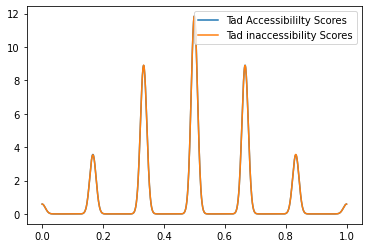

In [39]:
# plot score distribution 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import linspace

access_scores = []
inaccess_scores = []
for read in tad_access_scores:
    for kmer in tad_access_scores[read]:
        access_scores.append(tad_access_scores[read][kmer][0])
        inaccess_scores.append(tad_access_scores[read][kmer][1])


access_scores = np.array(access_scores)
inaccess_scores = np.array(inaccess_scores)

kde = gaussian_kde(access_scores)
kde2 = gaussian_kde(inaccess_scores)


dist_space = linspace( 0, 1, 1000 )

plt.plot( dist_space, kde(dist_space) )
plt.plot( dist_space, kde2(dist_space) )
plt.legend(['Tad Accessibililty Scores', 'Tad inaccessibility Scores'])




# Build Transition and Probability Matrices

### HMM with emission matrix from score distribution

In [9]:
mod_file = '/data16/liam/testing/HMM_test_data_80.txt'
pred_file = '/data16/liam/testing/HMM_test_data_pred_80_kde.txt'

emission_pos_file = '/data16/liam/testing/kde_vector_80.txt'
emission_neg_file = '/data16/liam/testing/kde_vector_mock.txt'

emission_pos_array = []
with open(emission_pos_file) as f:
    for line in f:
        emission_pos_array.append(float(line.rstrip()))
emission_pos_array = np.array(emission_pos_array)
emission_neg_array = []
with open(emission_neg_file) as f:
    for line in f:
        emission_neg_array.append(float(line.rstrip()))
emission_neg_array = np.array(emission_neg_array)

# get access scores from pickle
with open('/data16/liam/testing/tad_access_scores_80.pkl', 'rb') as f:
    tad_access_scores = pickle.load(f)

In [11]:
outDict = {}
with open (mod_file) as mf:
    with open(pred_file, 'w') as pf:
        mod_map, read_dict = build_modification_map2(mf)
        
        
        for read, modList in mod_map.items():
            # check that edits and ground truth are same length
            assert len(read_dict[read][0]) == len(read_dict[read][1]), 'edits and ground truth are not the same length'

            read_length = len(read_dict[read][0])
            calling_vec = make_calling_vector(modList, read_length) 

            # initialize probability matrix
            prob_mat = np.array([[0.0] * 31 for _ in range(read_length+1)]) 
            
            # initialize pointer matrix
            ptr_mat = np.array([[-1] * 31 for _ in range(read_length+1)])
        

            initial_rate = 1 / 31.0
            log_initial_rate = math.log(initial_rate)


            for j in range(0,31):
                # initialize initial probability
                prob_mat[1][j] = log_initial_rate
                ptr_mat[1][j] = 0

            for i in range(1, read_length+1): # changed to 1, read_length+1 from 2, read_length + 1
                within_linker = 0.0
                back_frm_ribosome = 0.0

                kmer = str(i-1) + '_' + str(i+5)
                if kmer in tad_access_scores[read]:
                    tad_access_score = tad_access_scores[read][kmer][0]
                    tad_inaccess_score = tad_access_scores[read][kmer][1]
                else:
                    tad_access_score = 0.5
                    tad_inaccess_score = 0.5
                    
                a_score = math.log(tad_access_score) if tad_access_score != 0 else 0
                i_score = math.log(tad_inaccess_score) if tad_inaccess_score != 0 else 0
                # if i is not an A
                if calling_vec[i] == -1: # calling vector is -1 at non A positions
                    # within linker probability is same as previous
                    within_linker = prob_mat[i-1][0]
                    # if not in first row of matrix
                    if prob_mat[i-1][30] != 0:
                        back_frm_ribosome = prob_mat[i-1][30] 

                else:
                    # i is an A
                    k = int(calling_vec[i] * 1000)
                    # within_linker = log_norm_density(calling_vec[i], k, emission_pos_array) + prob_mat[i-1][0]
                    # within_linker = math.log(emission_pos_array[k]) + prob_mat[i-1][0] - i_score 
                    within_linker = math.log(emission_pos_array[k]) + prob_mat[i-1][0] # use this line with 80% data
                    if prob_mat[i-1][30] != 0:
                        # back_frm_ribosome = log_norm_density(calling_vec[i], k, emission_pos_array) + prob_mat[i-1][30]
                        back_frm_ribosome = math.log(emission_pos_array[k]) + a_score + prob_mat[i-1][30]
                        
                #if probability that we are in the footprint is greater than the probability that we are in the linker
                if back_frm_ribosome != 0 and back_frm_ribosome > within_linker:
                    prob_mat[i][0] = back_frm_ribosome
                    ptr_mat[i][0] = 30 #update pointer matrix
                # if the probability that the previous nucleotide was in the linker is greater
                else:
                    prob_mat[i][0] = within_linker
                    ptr_mat[i][0] = 0

                if calling_vec[i] == -1:
                    prob_mat[i][1] = prob_mat[i - 1][0]
                else:
                    k = int(calling_vec[i] * 1000)
                    # prob_mat[i][1] = log_norm_density(calling_vec[i], k, emission_neg_array) + prob_mat[i - 1][0]
                    prob_mat[i][1] = math.log(emission_neg_array[k]) + a_score + prob_mat[i - 1][0] 
                ptr_mat[i][1] = 0

                for j in range(2, 31):
                    if calling_vec[i] == -1:
                        if prob_mat[i-1][j-1] != 0:
                            prob_mat[i][j] = prob_mat[i-1][j-1]
                    else:
                        k = int(calling_vec[i] * 1000)
                        # k = 3
                        if prob_mat[i-1][j-1] != 0:
                            # prob_mat[i][j] = log_norm_density(calling_vec[i], k, emission_neg_array) + prob_mat[i-1][j-1]
                            prob_mat[i][j] = math.log(emission_neg_array[k]) + a_score + prob_mat[i-1][j-1]
                    if prob_mat[i][j] != 0:
                        ptr_mat[i][j] = j-1
            
            # set max probability to super low number
            max_prob = -10000000.0
            # set max index to -1, which will be used to index the backtrack vector
            max_index = -1
            # iterate through the last row of the probability matrix to find the max probability
            for j in range(31):
                # if the probability of the last nucleotide being in the ribosome is greater than the max probability
                if prob_mat[read_length][j] > max_prob:
                    # set the max probability to the probability of the last nucleotide being in the ribosome
                    max_prob = prob_mat[read_length][j]
                    # set the max index to the index of the last nucleotide being in the ribosome
                    max_index = j
            
            # initialize backtrack vector
            backtrack_vec = []
            # for i in range(read_length, 0, -1):
            for i in range(len(ptr_mat)-1, 0, -1):
                # append the max index to the backtrack vector
                backtrack_vec.append(max_index) 
                # set the max index to the index of the previous nucleotide
                max_index = ptr_mat[i-1][max_index] # added ptr_mat[i-1][max_index] instead of ptr_mat[i][max_index], Dec 21, 2023
            # reverse the backtrack vector
            backtrack_vec.reverse()
            
            pred = ''
            
            for i in range(len(backtrack_vec)):
                if backtrack_vec[i] > 0:
                    pred += 'y'
                else:
                    pred += 'x'


            if len(pred) != len(read_dict[read][1]):
                print('prediction and ground truth are not the same length')
                print('pred: ')
                print(pred)
                print('true: ')
                print(read_dict[read][1])
                sys.exit()
            outDict[read] = [pred, read_dict[read][1]]



            #### write prediction to file ####
            pf.write(read + '\n')
            pf.write('pred:' + '\n')
            pf.write(pred + '\n')
            pf.write('true:' + '\n')
            pf.write(read_dict[read][1] + '\n')
            pf.write('modifications:' + '\n')
            pf.write(''.join(str(i) for i in read_dict[read][0]) + '\n')

### write transition matrix to file ####
with open('/data16/liam/testing/transition_mat.txt', 'w') as tm:
    tm.write('read_length: ' + str(len(read_dict[read][1])) + '\t' + 'prediction_length: ' + str(len(pred)) + '\t' + 
             'matrix_length: ' + str(ptr_mat.shape[0]) + '\t'+ 'backtrack_vec: ' + str(len(backtrack_vec)) + '\n')
    tm.write(read)
    tm.write('\n')
    tm.write('\t'.join(str(i) for i in ptr_mat[0]))
    tm.write('\n')
    tm.write('\t'.join(str(i) for i in ptr_mat[1]) + '\t' + str(calling_vec[0]) + '\t' + read_dict[read][1][0] + '\t' + pred[0] + '\t' + str(backtrack_vec[0]))
    tm.write('\n')
    for j in range(1, len(ptr_mat)):
        tm.write('\t'.join(str(i) for i in ptr_mat[j]) + '\t' + str(calling_vec[j]) + '\t' + read_dict[read][1][j-1] + '\t' + pred[j-1] + '\t' + str(backtrack_vec[j-1]))
        tm.write('\n')

### write probability matrix to file ####
with open('/data16/liam/testing/probability_mat.txt','w') as pm:
    pm.write('read_length: ' + str(len(read_dict[read][1])) + '\t' + 'prediction_length: ' + str(len(pred)) + '\t' + 
             'matrix_length: ' + str(prob_mat.shape[0]) + '\t' + 'backtrack_vec: ' + str(len(backtrack_vec)) + '\n')
    pm.write(read)
    pm.write('\n')
    pm.write('\t'.join(str(i) for i in prob_mat[0]))
    pm.write('\n')
    pm.write('\t'.join(str(i) for i in prob_mat[1]) + '\t' + str(calling_vec[0]) + '\t' + read_dict[read][1][0] + '\t' + pred[0] + '\t' + str(backtrack_vec[0]))
    pm.write('\n')
    for j in range(1, len(prob_mat)):
        pm.write('\t'.join(str(i) for i in prob_mat[j]) + '\t' + str(calling_vec[j]) + '\t' + read_dict[read][1][j-1] + '\t' + pred[j-1] + '\t' + str(backtrack_vec[j-1]))
        pm.write('\n')


## Let's Make Some Accuracy Metrics

### Plot number of predictions vs number of ground truth ribosomes

In [1]:
def count_ribosome_footprints(predicted_data, ground_truth_data, footprint_char='y'):
    '''
    This functions counts the number of ribosome footprints in the predicted and ground truth data
    '''
    predicted_count = len([footprint for footprint in predicted_data.split('x') if footprint])
    ground_truth_count = len([footprint for footprint in ground_truth_data.split('x') if footprint])
    
    return predicted_count, ground_truth_count

In [2]:
def parse_pred_file(filename):
    reads = []
    with open(filename, 'r') as file:
        while True:
            read_name = file.readline().strip()
            if not read_name:
                break
            file.readline()  # Skip 'pred:' line
            predicted_sequence = file.readline().strip()
            file.readline()  # Skip 'true:' line
            true_sequence = file.readline().strip()
            file.readline()  # Skip 'modifications:' line
            modifications = file.readline().strip()
            reads.append((read_name, predicted_sequence, true_sequence, modifications))
    return reads

In [3]:
reads_100 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_30only_kde.txt')
read_footprint_100 = {}
# get footprint info for each read
for read in reads_100:
    read_footprint_100[read[0]] = count_ribosome_footprints(read[1], read[2])
read_footprint_100

{'read_0': (2, 2),
 'read_1': (16, 16),
 'read_2': (15, 15),
 'read_3': (10, 10),
 'read_4': (15, 15),
 'read_5': (8, 8),
 'read_6': (12, 12),
 'read_7': (8, 8),
 'read_8': (12, 12),
 'read_9': (13, 13),
 'read_10': (9, 9),
 'read_11': (11, 11),
 'read_12': (7, 7),
 'read_13': (13, 13),
 'read_14': (3, 3),
 'read_15': (12, 12),
 'read_16': (16, 16),
 'read_17': (14, 14),
 'read_18': (9, 9),
 'read_19': (14, 14),
 'read_20': (3, 3),
 'read_21': (3, 3),
 'read_22': (18, 18),
 'read_23': (10, 10),
 'read_24': (8, 8),
 'read_25': (3, 3),
 'read_26': (14, 14),
 'read_27': (13, 13),
 'read_28': (10, 10),
 'read_29': (12, 12),
 'read_30': (13, 13),
 'read_31': (5, 5),
 'read_32': (5, 5),
 'read_33': (16, 16),
 'read_34': (11, 11),
 'read_35': (4, 4),
 'read_36': (3, 3),
 'read_37': (19, 19),
 'read_38': (5, 5),
 'read_39': (18, 18),
 'read_40': (7, 7),
 'read_41': (5, 5),
 'read_42': (13, 13),
 'read_43': (8, 8),
 'read_44': (3, 3),
 'read_45': (4, 4),
 'read_46': (2, 2),
 'read_47': (11, 11)

In [4]:
reads_80 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_80_kde.txt')
read_footprint_80 = {}
# get footprint info for each read
for read in reads_80:
    read_footprint_80[read[0]] = count_ribosome_footprints(read[1], read[2])
read_footprint_80

{'read_0': (8, 7),
 'read_1': (13, 12),
 'read_2': (7, 6),
 'read_3': (19, 19),
 'read_4': (5, 5),
 'read_5': (17, 17),
 'read_6': (11, 11),
 'read_7': (3, 4),
 'read_8': (17, 15),
 'read_9': (7, 6),
 'read_10': (7, 6),
 'read_11': (4, 4),
 'read_12': (11, 11),
 'read_13': (16, 16),
 'read_14': (7, 6),
 'read_15': (5, 5),
 'read_16': (3, 3),
 'read_17': (11, 10),
 'read_18': (20, 16),
 'read_19': (5, 5),
 'read_20': (5, 4),
 'read_21': (17, 16),
 'read_22': (8, 6),
 'read_23': (19, 18),
 'read_24': (8, 8),
 'read_25': (17, 17),
 'read_26': (11, 9),
 'read_27': (8, 8),
 'read_28': (6, 4),
 'read_29': (18, 15),
 'read_30': (6, 6),
 'read_31': (16, 15),
 'read_32': (15, 12),
 'read_33': (7, 7),
 'read_34': (22, 19),
 'read_35': (7, 6),
 'read_36': (13, 12),
 'read_37': (20, 19),
 'read_38': (18, 16),
 'read_39': (9, 8),
 'read_40': (19, 18),
 'read_41': (12, 12),
 'read_42': (7, 7),
 'read_43': (15, 13),
 'read_44': (13, 12),
 'read_45': (10, 8),
 'read_46': (5, 5),
 'read_47': (5, 5),
 '

In [5]:
reads_50 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_50_kde.txt')
read_footprint_50 = {}
# get footprint info for each read
for read in reads_50:
    read_footprint_50[read[0]] = count_ribosome_footprints(read[1], read[2])
read_footprint_50

{'read_0': (8, 8),
 'read_1': (18, 17),
 'read_2': (16, 14),
 'read_3': (18, 14),
 'read_4': (3, 2),
 'read_5': (11, 11),
 'read_6': (14, 14),
 'read_7': (10, 12),
 'read_8': (12, 9),
 'read_9': (20, 14),
 'read_10': (8, 5),
 'read_11': (6, 5),
 'read_12': (9, 6),
 'read_13': (14, 14),
 'read_14': (6, 8),
 'read_15': (9, 10),
 'read_16': (6, 5),
 'read_17': (24, 21),
 'read_18': (10, 10),
 'read_19': (16, 15),
 'read_20': (12, 12),
 'read_21': (15, 9),
 'read_22': (5, 5),
 'read_23': (6, 5),
 'read_24': (8, 7),
 'read_25': (15, 15),
 'read_26': (20, 17),
 'read_27': (6, 5),
 'read_28': (11, 9),
 'read_29': (19, 17),
 'read_30': (15, 18),
 'read_31': (8, 7),
 'read_32': (10, 8),
 'read_33': (22, 20),
 'read_34': (9, 8),
 'read_35': (15, 15),
 'read_36': (6, 4),
 'read_37': (14, 11),
 'read_38': (11, 11),
 'read_39': (21, 15),
 'read_40': (7, 6),
 'read_41': (18, 17),
 'read_42': (18, 16),
 'read_43': (5, 4),
 'read_44': (9, 8),
 'read_45': (10, 8),
 'read_46': (12, 10),
 'read_47': (13,

In [6]:
reads_DE50 = parse_pred_file('/data16/liam/testing/HMM_test_data_pred_AC50_kde.txt')
read_footprint_DE50 = {}
# get footprint info for each read
for read in reads_DE50:
    read_footprint_DE50[read[0]] = count_ribosome_footprints(read[1], read[2])
read_footprint_DE50

{'read_0': (13, 13),
 'read_1': (4, 3),
 'read_2': (16, 15),
 'read_3': (17, 20),
 'read_4': (13, 12),
 'read_5': (5, 6),
 'read_6': (18, 19),
 'read_7': (2, 4),
 'read_8': (6, 6),
 'read_9': (9, 7),
 'read_10': (12, 15),
 'read_11': (18, 18),
 'read_12': (6, 6),
 'read_13': (14, 14),
 'read_14': (9, 10),
 'read_15': (9, 8),
 'read_16': (15, 15),
 'read_17': (19, 18),
 'read_18': (5, 4),
 'read_19': (16, 18),
 'read_20': (5, 5),
 'read_21': (3, 3),
 'read_22': (3, 2),
 'read_23': (12, 13),
 'read_24': (8, 7),
 'read_25': (20, 19),
 'read_26': (21, 20),
 'read_27': (5, 4),
 'read_28': (7, 7),
 'read_29': (18, 17),
 'read_30': (15, 16),
 'read_31': (9, 11),
 'read_32': (6, 7),
 'read_33': (5, 3),
 'read_34': (9, 9),
 'read_35': (12, 11),
 'read_36': (12, 13),
 'read_37': (9, 9),
 'read_38': (10, 11),
 'read_39': (18, 17),
 'read_40': (9, 9),
 'read_41': (15, 15),
 'read_42': (20, 19),
 'read_43': (14, 13),
 'read_44': (8, 8),
 'read_45': (11, 12),
 'read_46': (13, 13),
 'read_47': (11, 1

In [7]:
# plot number of reads where predicted footprint count is equal to ground truth footprint count
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

plot_dict = {'100%': None,
             '80%': None,
             '50%': None}
total_100 = len(read_footprint_100)
num_100 = 0

for read in read_footprint_100:
    if read_footprint_100[read][0] == read_footprint_100[read][1]:
        num_100 += 1

plot_dict['100%'] = (num_100, total_100)

total_80 = len(read_footprint_80)
num_80 = 0
for read in read_footprint_80:
    if read_footprint_80[read][0] == read_footprint_80[read][1]:
        num_80 += 1

plot_dict['80%'] = (num_80, total_80)

total_50 = len(read_footprint_50)
num_50 = 0

for read in read_footprint_50:
    if read_footprint_50[read][0] == read_footprint_50[read][1]:
        num_50 += 1

plot_dict['50%'] = (num_50, total_50)

total_DE50 = len(read_footprint_DE50)
num_DE50 = 0

for read in read_footprint_DE50:
    if read_footprint_DE50[read][0] == read_footprint_DE50[read][1]:
        num_DE50 += 1

plot_dict['DE50%'] = (num_DE50, total_DE50)

plot_dict

{'100%': (996, 1000),
 '80%': (382, 1000),
 '50%': (180, 999),
 'DE50%': (426, 1000)}

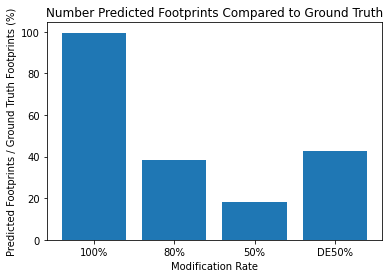

In [8]:
import matplotlib.pyplot as plt

# Extract the data from plot_dict
labels = list(plot_dict.keys())
values = [round((num / total) * 100, 2) for num, total in plot_dict.values()]

# Create the bar plot
plt.bar(labels, values)

# Add labels and title
plt.xlabel('Modification Rate')
plt.ylabel('Predicted Footprints / Ground Truth Footprints (%)')
plt.title('Number Predicted Footprints Compared to Ground Truth')

# Show the plot
plt.show()


In [9]:
deviations = []
for read in read_footprint_100:
    diff = read_footprint_100[read][1] - read_footprint_100[read][0]
    deviations.append(diff)
dev_100 = np.mean(deviations)

deviations = []
for read in read_footprint_80:
    diff = read_footprint_80[read][1] - read_footprint_80[read][0]
    deviations.append(diff)
dev_80 = np.mean(deviations)

deviations = []
for read in read_footprint_50:
    diff = read_footprint_50[read][1] - read_footprint_50[read][0]
    deviations.append(diff)
dev_50 = np.mean(deviations)

deviations = []
for read in read_footprint_DE50:
    diff = read_footprint_DE50[read][1] - read_footprint_DE50[read][0]
    deviations.append(diff)
dev_DE50 = np.mean(deviations)

dev_100, dev_80, dev_50, dev_DE50

(0.004, -1.024, -1.5925925925925926, -0.198)

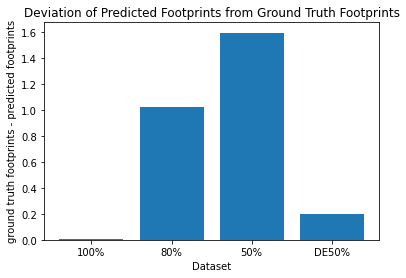

In [10]:
import matplotlib.pyplot as plt

# Create a list of dataset names
datasets = ['100%', '80%', '50%', 'DE50%']

# Create a list of deviations
deviations = [abs(dev_100), abs(dev_80), abs(dev_50), abs(dev_DE50)]

# Create the bar plot
plt.bar(datasets, deviations)

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('ground truth footprints - predicted footprints')
plt.title('Deviation of Predicted Footprints from Ground Truth Footprints')

# Show the plot
plt.show()


### Overlap of Footprints

In [11]:
def get_all_footprint_indices(data, footprint_char='y'):
    '''
    This function returns a list of tuples containing the start and end indices of all footprints in the data
    '''
    footprints = []
    start_index = None

    for i in range(len(data)):
        if data[i] == footprint_char and start_index is None:
            start_index = i
        elif data[i] != footprint_char and start_index is not None:
            footprints.append((start_index, i - 1))
            start_index = None

    if start_index is not None:
        footprints.append((start_index, len(data) - 1))

    return footprints

In [12]:
def calculate_overlap(predicted_start, predicted_end, ground_truth_start, ground_truth_end):
    '''
    calculates the overlap between two footprints
    '''
    overlap_start = max(predicted_start, ground_truth_start)
    overlap_end = min(predicted_end, ground_truth_end)
    
    if overlap_end >= overlap_start:
        overlap = overlap_end - overlap_start + 1
    else:
        overlap = 0
    
    return overlap

In [13]:
def count_overlapping_footprints(list1, list2):
    count = 0
    for footprint1 in list1:
        for footprint2 in list2:
            if footprint1[1] >= footprint2[0] and footprint1[0] <= footprint2[1]:
                count += 1
                break
    return count


In [14]:
overlap_100 = {}

for read in reads_100:
    
    predicted = get_all_footprint_indices(read[1])
    ground_truth = get_all_footprint_indices(read[2])

    overlap_100[read[0]] = [count_overlapping_footprints(predicted, ground_truth), len(ground_truth)]
            

overlap_100



{'read_0': [2, 2],
 'read_1': [16, 16],
 'read_2': [15, 15],
 'read_3': [10, 10],
 'read_4': [15, 15],
 'read_5': [8, 8],
 'read_6': [12, 12],
 'read_7': [8, 8],
 'read_8': [12, 12],
 'read_9': [13, 13],
 'read_10': [9, 9],
 'read_11': [11, 11],
 'read_12': [7, 7],
 'read_13': [13, 13],
 'read_14': [3, 3],
 'read_15': [12, 12],
 'read_16': [16, 16],
 'read_17': [14, 14],
 'read_18': [9, 9],
 'read_19': [14, 14],
 'read_20': [3, 3],
 'read_21': [3, 3],
 'read_22': [18, 18],
 'read_23': [10, 10],
 'read_24': [8, 8],
 'read_25': [3, 3],
 'read_26': [14, 14],
 'read_27': [13, 13],
 'read_28': [10, 10],
 'read_29': [12, 12],
 'read_30': [13, 13],
 'read_31': [5, 5],
 'read_32': [5, 5],
 'read_33': [16, 16],
 'read_34': [11, 11],
 'read_35': [4, 4],
 'read_36': [3, 3],
 'read_37': [19, 19],
 'read_38': [5, 5],
 'read_39': [18, 18],
 'read_40': [7, 7],
 'read_41': [5, 5],
 'read_42': [13, 13],
 'read_43': [8, 8],
 'read_44': [3, 3],
 'read_45': [4, 4],
 'read_46': [2, 2],
 'read_47': [11, 11]

In [15]:
overlap_80 = {}

for read in reads_80:
    
    predicted = get_all_footprint_indices(read[1])
    ground_truth = get_all_footprint_indices(read[2])

    overlap_80[read[0]] = [count_overlapping_footprints(predicted, ground_truth), len(ground_truth)]
            

overlap_80

{'read_0': [7, 7],
 'read_1': [12, 12],
 'read_2': [6, 6],
 'read_3': [19, 19],
 'read_4': [5, 5],
 'read_5': [17, 17],
 'read_6': [11, 11],
 'read_7': [3, 4],
 'read_8': [15, 15],
 'read_9': [6, 6],
 'read_10': [6, 6],
 'read_11': [4, 4],
 'read_12': [11, 11],
 'read_13': [16, 16],
 'read_14': [6, 6],
 'read_15': [5, 5],
 'read_16': [3, 3],
 'read_17': [10, 10],
 'read_18': [17, 16],
 'read_19': [5, 5],
 'read_20': [4, 4],
 'read_21': [16, 16],
 'read_22': [6, 6],
 'read_23': [18, 18],
 'read_24': [8, 8],
 'read_25': [17, 17],
 'read_26': [9, 9],
 'read_27': [8, 8],
 'read_28': [4, 4],
 'read_29': [16, 15],
 'read_30': [6, 6],
 'read_31': [15, 15],
 'read_32': [12, 12],
 'read_33': [7, 7],
 'read_34': [19, 19],
 'read_35': [6, 6],
 'read_36': [12, 12],
 'read_37': [19, 19],
 'read_38': [17, 16],
 'read_39': [8, 8],
 'read_40': [18, 18],
 'read_41': [12, 12],
 'read_42': [7, 7],
 'read_43': [14, 13],
 'read_44': [12, 12],
 'read_45': [8, 8],
 'read_46': [5, 5],
 'read_47': [5, 5],
 're

In [16]:
overlap_50 = {}

for read in reads_50:
    
    predicted = get_all_footprint_indices(read[1])
    ground_truth = get_all_footprint_indices(read[2])

    overlap_50[read[0]] = [count_overlapping_footprints(predicted, ground_truth), len(ground_truth)]
            

overlap_50



{'read_0': [6, 8],
 'read_1': [15, 17],
 'read_2': [13, 14],
 'read_3': [13, 14],
 'read_4': [2, 2],
 'read_5': [9, 11],
 'read_6': [10, 14],
 'read_7': [9, 12],
 'read_8': [7, 9],
 'read_9': [14, 14],
 'read_10': [5, 5],
 'read_11': [3, 5],
 'read_12': [6, 6],
 'read_13': [11, 14],
 'read_14': [6, 8],
 'read_15': [8, 10],
 'read_16': [3, 5],
 'read_17': [18, 21],
 'read_18': [8, 10],
 'read_19': [13, 15],
 'read_20': [9, 12],
 'read_21': [9, 9],
 'read_22': [5, 5],
 'read_23': [5, 5],
 'read_24': [7, 7],
 'read_25': [12, 15],
 'read_26': [17, 17],
 'read_27': [5, 5],
 'read_28': [9, 9],
 'read_29': [16, 17],
 'read_30': [12, 18],
 'read_31': [6, 7],
 'read_32': [8, 8],
 'read_33': [19, 20],
 'read_34': [6, 8],
 'read_35': [10, 15],
 'read_36': [3, 4],
 'read_37': [11, 11],
 'read_38': [9, 11],
 'read_39': [15, 15],
 'read_40': [6, 6],
 'read_41': [15, 17],
 'read_42': [14, 16],
 'read_43': [4, 4],
 'read_44': [8, 8],
 'read_45': [8, 8],
 'read_46': [9, 10],
 'read_47': [10, 11],
 'rea

In [17]:
overlap_DE50 = {}

for read in reads_DE50:
    
    predicted = get_all_footprint_indices(read[1])
    ground_truth = get_all_footprint_indices(read[2])

    overlap_DE50[read[0]] = [count_overlapping_footprints(predicted, ground_truth), len(ground_truth)]
            

overlap_DE50

{'read_0': [12, 13],
 'read_1': [3, 3],
 'read_2': [15, 15],
 'read_3': [17, 20],
 'read_4': [12, 12],
 'read_5': [5, 6],
 'read_6': [18, 19],
 'read_7': [2, 4],
 'read_8': [6, 6],
 'read_9': [7, 7],
 'read_10': [12, 15],
 'read_11': [17, 18],
 'read_12': [6, 6],
 'read_13': [13, 14],
 'read_14': [9, 10],
 'read_15': [8, 8],
 'read_16': [15, 15],
 'read_17': [18, 18],
 'read_18': [4, 4],
 'read_19': [16, 18],
 'read_20': [4, 5],
 'read_21': [3, 3],
 'read_22': [2, 2],
 'read_23': [12, 13],
 'read_24': [7, 7],
 'read_25': [19, 19],
 'read_26': [20, 20],
 'read_27': [4, 4],
 'read_28': [7, 7],
 'read_29': [17, 17],
 'read_30': [15, 16],
 'read_31': [9, 11],
 'read_32': [5, 7],
 'read_33': [3, 3],
 'read_34': [9, 9],
 'read_35': [12, 11],
 'read_36': [12, 13],
 'read_37': [8, 9],
 'read_38': [10, 11],
 'read_39': [17, 17],
 'read_40': [9, 9],
 'read_41': [15, 15],
 'read_42': [19, 19],
 'read_43': [13, 13],
 'read_44': [8, 8],
 'read_45': [11, 12],
 'read_46': [13, 13],
 'read_47': [11, 1

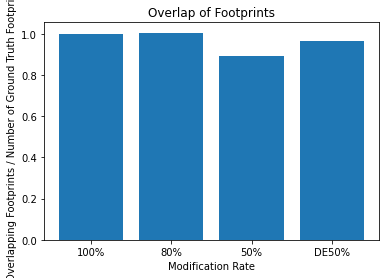

In [18]:
import matplotlib.pyplot as plt
import numpy as np
# Extract the data from the overlap dictionaries
overlap_100_values = []
for read in overlap_100:
    overlap_100_values.append(overlap_100[read][0] / overlap_100[read][1])
overlap_100_values = np.mean(overlap_100_values)

overlap_80_values = []
for read in overlap_80:
    overlap_80_values.append(overlap_80[read][0] / overlap_80[read][1])
overlap_80_values = np.mean(overlap_80_values)

overlap_50_values = []
for read in overlap_50:
    overlap_50_values.append(overlap_50[read][0] / overlap_50[read][1])
overlap_50_values = np.mean(overlap_50_values)

overlap_DE50_values = []
for read in overlap_DE50:
    overlap_DE50_values.append(overlap_DE50[read][0] / overlap_DE50[read][1])
overlap_DE50_values = np.mean(overlap_DE50_values)


# Create the bar plot
plt.bar(['100%', '80%', '50%', 'DE50%'], [overlap_100_values, overlap_80_values, overlap_50_values, overlap_DE50_values])

# Add labels and title
plt.xlabel('Modification Rate')
plt.ylabel('Overlapping Footprints / Number of Ground Truth Footprints')
plt.title('Overlap of Footprints')

# Show the plot
plt.show()


### Number of Predicted Footprints vs Number of Ground Truth Footprints #######

1000


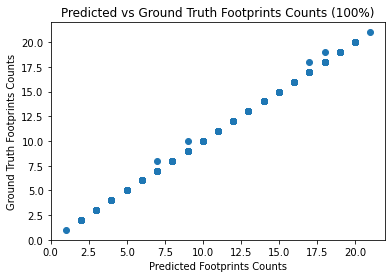

In [29]:
import matplotlib.pyplot as plt

# Extract the data from the reads dictionaries
predicted_counts = []
ground_truth_counts = []

for read in read_footprint_100:
    predicted_counts.append(read_footprint_100[read][0])
    ground_truth_counts.append(read_footprint_100[read][1])

# for read in read_footprint_80:
#     predicted_counts.append(read_footprint_80[read][0])
#     ground_truth_counts.append(read_footprint_80[read][1])

# for read in read_footprint_50:
#     predicted_counts.append(read_footprint_50[read][0])
#     ground_truth_counts.append(read_footprint_50[read][1])

# Create the scatter plot
plt.scatter(predicted_counts, ground_truth_counts)

# Add labels and title
plt.xlabel('Predicted Footprints Counts')
plt.ylabel('Ground Truth Footprints Counts')
plt.title('Predicted vs Ground Truth Footprints Counts (100%)')

# Show the plot
plt.show()


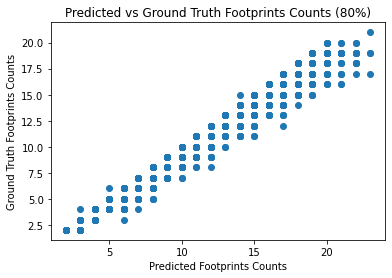

In [27]:
import matplotlib.pyplot as plt

# Extract the data from the reads dictionaries
predicted_counts = []
ground_truth_counts = []

# for read in read_footprint_100:
#     predicted_counts.append(read_footprint_100[read][0])
#     ground_truth_counts.append(read_footprint_100[read][1])

for read in read_footprint_80:
    predicted_counts.append(read_footprint_80[read][0])
    ground_truth_counts.append(read_footprint_80[read][1])

# for read in read_footprint_50:
#     predicted_counts.append(read_footprint_50[read][0])
#     ground_truth_counts.append(read_footprint_50[read][1])

# Create the scatter plot
plt.scatter(predicted_counts, ground_truth_counts)

# Add labels and title
plt.xlabel('Predicted Footprints Counts')
plt.ylabel('Ground Truth Footprints Counts')
plt.title('Predicted vs Ground Truth Footprints Counts (80%)')

# Show the plot
plt.show()


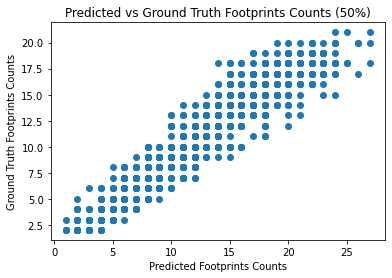

In [28]:
import matplotlib.pyplot as plt

# Extract the data from the reads dictionaries
predicted_counts = []
ground_truth_counts = []

# for read in read_footprint_100:
#     predicted_counts.append(read_footprint_100[read][0])
#     ground_truth_counts.append(read_footprint_100[read][1])

# for read in read_footprint_80:
#     predicted_counts.append(read_footprint_80[read][0])
#     ground_truth_counts.append(read_footprint_80[read][1])

for read in read_footprint_50:
    predicted_counts.append(read_footprint_50[read][0])
    ground_truth_counts.append(read_footprint_50[read][1])

# Create the scatter plot
plt.scatter(predicted_counts, ground_truth_counts)

# Add labels and title
plt.xlabel('Predicted Footprints Counts')
plt.ylabel('Ground Truth Footprints Counts')
plt.title('Predicted vs Ground Truth Footprints Counts (50%)')

# Show the plot
plt.show()


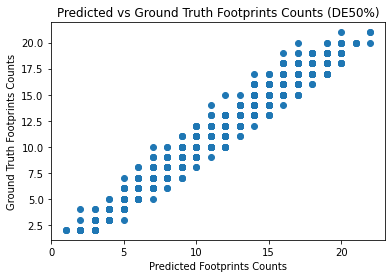

In [19]:
import matplotlib.pyplot as plt

# Extract the data from the reads dictionaries
predicted_counts = []
ground_truth_counts = []


for read in read_footprint_DE50:
    predicted_counts.append(read_footprint_DE50[read][0])
    ground_truth_counts.append(read_footprint_DE50[read][1])

# Create the scatter plot
plt.scatter(predicted_counts, ground_truth_counts)

# Add labels and title
plt.xlabel('Predicted Footprints Counts')
plt.ylabel('Ground Truth Footprints Counts')
plt.title('Predicted vs Ground Truth Footprints Counts (DE50%)')

# Show the plot
plt.show()


### Old Code, will probably delete 

In [ ]:
# need to create fake reads to insert dummy -1 values at non A positions
# mod_file = '/data16/liam/testing/HMM_test_data_30only.txt'
# pred_file = '/data16/liam/testing/HMM_test_data_30only_pred.txt'
# emission_mat = [0.97, 0.03]
mod_file = '/data16/liam/testing/HMM_test_data_80.txt'
pred_file = '/data16/liam/testing/HMM_test_data_80_pred.txt'
# probability of linker mod, probability of footprint mod
emission_mat = [0.8, 0.03]
# mod_file = '/data16/liam/testing/HMM_test_data_50.txt'
# pred_file = '/data16/liam/testing/HMM_test_data_50_pred.txt'
# emission_mat = [0.5, 0.5]
# mod_file = '/data16/liam/testing/HMM_test_data_25.txt'
# pred_file = '/data16/liam/testing/HMM_test_data_25_pred.txt'
# emission_mat = [0.25, 0.75]
outDict = {}
with open (mod_file) as mf:
    with open(pred_file, 'w') as pf:
        mod_map, read_dict = build_modification_map(mf, emission_mat)
        
        
        for read, modList in mod_map.items():
            # check that edits and ground truth are same length
            assert len(read_dict[read][0]) == len(read_dict[read][1]), 'edits and ground truth are not the same length'

            read_length = len(read_dict[read][0])
            calling_vec = make_calling_vector(modList, read_length) 

            # initialize probability matrix
            prob_mat = np.array([[0.0] * 31 for _ in range(read_length+1)]) 
            
            # initialize pointer matrix
            ptr_mat = np.array([[-1] * 31 for _ in range(read_length+1)])
        

            initial_rate = 1 / 31.0
            log_initial_rate = math.log(initial_rate)


            for j in range(0,31):
                # initialize initial probability
                prob_mat[1][j] = log_initial_rate
                ptr_mat[1][j] = 0

            for i in range(1, read_length+1): # changed to 1, read_length+1 from 2, read_length + 1
                within_linker = 0.0
                back_frm_ribosome = 0.0
                # if i is not an A
                if calling_vec[i] == -1: # calling vector is -1 at non A positions
                    # within linker probability is same as previous
                    within_linker = prob_mat[i-1][0]
                    # if not in first row of matrix
                    if prob_mat[i-1][30] != 0:
                        back_frm_ribosome = prob_mat[i-1][30] 

                else:
                    # i is an A
                    k = int(calling_vec[i] * 100)
                    # if k == 97:
                    if k == emission_mat[0]*100: # mod
                        within_linker = math.log(k) + prob_mat[i-1][0]
                    # if k == 3:   
                    if k == emission_mat[1]*100: # no mod
                        if prob_mat[i-1][30] != 0:
                            back_frm_ribosome = math.log(k) + prob_mat[i-1][30]
                        
                #if probability that we are in the footprint is greater than the probability that we are in the linker
                if back_frm_ribosome != 0 and back_frm_ribosome > within_linker:
                    prob_mat[i][0] = back_frm_ribosome
                    ptr_mat[i][0] = 30 #update pointer matrix
                # if the probability that the previous nucleotide was in the linker is greater
                else:
                    prob_mat[i][0] = within_linker
                    ptr_mat[i][0] = 0

                if calling_vec[i] == -1:
                    prob_mat[i][1] = prob_mat[i - 1][0]
                else:
                    k = int(calling_vec[i] * 100)
                    # prob_mat[i][1] = log_norm_density(calling_vec[i], k, 0.03) + prob_mat[i - 1][0]
                    prob_mat[i][1] = math.log(k) + prob_mat[i - 1][0]
                ptr_mat[i][1] = 0

                for j in range(2, 31):
                    if calling_vec[i] == -1:
                        if prob_mat[i-1][j-1] != 0:
                            prob_mat[i][j] = prob_mat[i-1][j-1]
                    else:
                        k = int(calling_vec[i] * 100)
                        # k = 3
                        if prob_mat[i-1][j-1] != 0:
                            prob_mat[i][j] = math.log(k) + prob_mat[i-1][j-1]
                            # prob_mat[i][j] = log_norm_density(calling_vec[i], k, 0.03) + prob_mat[i-1][j-1]
                    if prob_mat[i][j] != 0:
                        ptr_mat[i][j] = j-1
            
            # set max probability to super low number
            max_prob = -10000000.0
            # set max index to -1, which will be used to index the backtrack vector
            max_index = -1
            # iterate through the last row of the probability matrix to find the max probability
            for j in range(31):
                # if the probability of the last nucleotide being in the ribosome is greater than the max probability
                if prob_mat[read_length][j] > max_prob:
                    # set the max probability to the probability of the last nucleotide being in the ribosome
                    max_prob = prob_mat[read_length][j]
                    # set the max index to the index of the last nucleotide being in the ribosome
                    max_index = j
            
            # initialize backtrack vector
            backtrack_vec = []
            # for i in range(read_length, 0, -1):
            for i in range(len(ptr_mat)-1, 0, -1):
                # append the max index to the backtrack vector
                backtrack_vec.append(max_index)
                # set the max index to the index of the previous nucleotide
                max_index = ptr_mat[i-1][max_index] # added ptr_mat[i-1][max_index] instead of ptr_mat[i][max_index], Dec 21, 2023
            # reverse the backtrack vector
            backtrack_vec.reverse()
            
            pred = ''
            
            for i in range(len(backtrack_vec)):
                if backtrack_vec[i] > 0:
                    pred += 'y'
                else:
                    pred += 'x'

            # #### Refine the prediction ####
            # edits = read_dict[read][0]
            # # print('read: ' + read)
            # # print('unrefined pred: ')
            # # print(pred)
            # for i in range(len(pred)):
            #     if pred[i] == 'y':
            #         # get footprint length
            #         footprint_length = 1
            #         while pred[i+footprint_length] == 'y' and footprint_length <= 30:
            #             footprint_length += 1
            #         block = pred[i:i+footprint_length]
            #         edit_block = edits[i:i+len(block)]
            #         # if there is an edit in the footprint
            #         if 1 in edit_block:
            #             # if the edit is in the first half of the footprint
            #             if edit_block[:len(edit_block)//2].count(1) > 0:
            #                 # shift the footprint to the right
            #                 shift = 1
            #                 while pred[i+shift] == 'y':
            #                     if edits[i+shift:i+shift+footprint_length].count(1) > 0:
            #                         shift += 1
            #                     else:
            #                         break
            #                 pred = pred[:i] + 'x'*shift + block + pred[i+shift+footprint_length:]
            #             # if the edit is in the second half of the footprint
            #             elif edit_block[len(edit_block)//2:].count(1) > 0:
            #                 # shift the footprint to the left
            #                 shift = 1
            #                 while pred[i+footprint_length-shift] == 'y':
            #                     if edits[i-shift:i-shift+footprint_length].count(1) > 0:
            #                         shift += 1
            #                     else:
            #                         break
            #                     shift += 1
            #                 pred = pred[:i-shift] + block + 'x'*shift + pred[i+footprint_length:]

                    # print('pred: ' )
                    # print(pred)
                    # print('true: ')
                    # print(read_dict[read][1])
                    # print('modifications: ')
                    # print(''.join(str(i) for i in read_dict[read][0]))
                    
                    # assert len(pred) == len(read_dict[read][1]), 'prediction and ground truth are not the same length'
            if len(pred) != len(read_dict[read][1]):
                print('prediction and ground truth are not the same length')
                print('pred: ')
                print(pred)
                print('true: ')
                print(read_dict[read][1])
                sys.exit()
            outDict[read] = [pred, read_dict[read][1]]

            
            # assert len(pred) == len(read_dict[read][1]), 'prediction and ground truth are not the same length' 
            # print('pred:')
            # print(pred)
            # print('true:')
            # print(read_dict[read][1])
            # print('modifications:')
            # print(''.join(str(i) for i in read_dict[read][0]))
            
            #### write transition matrix to file ####
            # with open('/data16/liam/testing/transition_mat.txt', 'w') as tm:
            #     tm.write('read_length: ' + str(len(read_dict[read][1])) + '\t' + 'prediction_length: ' + str(len(pred)) + '\t' + 
            #              'matrix_length: ' + str(ptr_mat.shape[0]) + '\t'+ 'backtrack_vec: ' + str(len(backtrack_vec)) + '\n')
            #     tm.write(read)
            #     tm.write('\n')
            #     tm.write('\t'.join(str(i) for i in ptr_mat[0]))
            #     tm.write('\n')
            #     tm.write('\t'.join(str(i) for i in ptr_mat[1]) + '\t' + str(calling_vec[0]) + '\t' + read_dict[read][1][0] + '\t' + pred[0] + '\t' + str(backtrack_vec[0]))
            #     tm.write('\n')
            #     for j in range(1, len(ptr_mat)):
            #         tm.write('\t'.join(str(i) for i in ptr_mat[j]) + '\t' + str(calling_vec[j]) + '\t' + read_dict[read][1][j-1] + '\t' + pred[j-1] + '\t' + str(backtrack_vec[j-1]))
            #         tm.write('\n')

            #### write prediction to file ####
            pf.write(read + '\n')
            pf.write('pred:' + '\n')
            pf.write(pred + '\n')
            pf.write('true:' + '\n')
            pf.write(read_dict[read][1] + '\n')
            pf.write('modifications:' + '\n')
            pf.write(''.join(str(i) for i in read_dict[read][0]) + '\n')


                
        #### backtracking to produce bed coordinates ####
        # # initialize variables to hold the start and end of the ribosome
        # rib_start = 0
        # rib_end = 0
        # InRibosome = False
        # print(backtrack_vec)
        # for i in range(len(backtrack_vec)):
        #     if backtrack_vec[i] > 0:
        #         if not InRibosome:
        #             # if the nucleotide is in the ribosome and the previous nucleotide was not in the ribosome
                    
        #             rib_start = i + 1
        #             pred += 'x'*(i-rib_end)
        #             InRibosome = True
        #     else:
        #         if InRibosome:
        #             # if the nucleotide is not in the ribosome and the previous nucleotide was in the ribosome
        #             rib_end = i + 1 
        #             pred += 'y'*(rib_end-i)
        #             InRibosome = False
        # if InRibosome:
        #     pred += 'y'*backtrack_vec[i]
